## Equações de Bellman dos jogadores para o modelo de Dou et al (2019)

In [1]:
#para mostrar todos os resultados e não apenas o último
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numba as nb
from numba import jit, njit, jitclass, prange, float64, int32
%matplotlib inline


import time

### Parâmetros do jogo

In [3]:
μ = 4.566 #número de meses entre períodos, traduz a quantidade de períodos t em quantidade de meses
# ρ = 0.884 # (1 - ρ) é a taxa de depreciação da empresa a cada período
ρ = 0.5 #testando nova taxa de depreciação
β = 9.84 #usamos aqui a distribuição Uniforme, depois vamos mudar isto
c0 = 0.044 #custo fixo de ir para a corte
c1 = 0.015 #custo variável de ir para a corte


hs0 = 0.28 #habilidade inicial de s
hj0 = 0.36 #habilidade inicial de j

λj = 0.346



Valores que virão dos dados

In [4]:
Vmax = float64(1.0) #valor máximo de reorganização da firma
L = float64(0.25) #valor inicial de liquidação da firma
Ds = float64(0.28) #valor da dívida com credor sênior
Dj = float64(0.35) #valor da dívida com credor júnior

D = Ds + Dj #valor total da dívida, usada para escalar custos, por exemplo


Definições iniciais: custo, valores de liquidação, valor máximo de reorganização da firma a cada período, número de rounds

In [5]:
#função custo
def Ct(t):
    if(t == 0):
        return 0
    else:
        return c0 * D + c1 * t * D
    
#test
Ct(0)    
Ct(1)


0

0.037169999999999995

In [6]:
#number of periods
def max_turns(Vmax, L, ρ):
    t = 0
    
    while(ρ**(t-1) * Vmax - Ct(t) > L - Ct(t)):
        t += 1
    return t
#     T = (np.log(L) - np.log(Vmax))/np.log(ρ) + 1
    
#     return int32(T)

T = max_turns(Vmax, L, ρ)
T


#array com custos em cada período
C = np.empty(T)

for t in range(T):
    C[t] = Ct(t)

3

In [7]:
#value of the firm in each period

def Vt(Vmax, Tmax, ρ):
    
    V = np.empty(Tmax)
    
    V[0] = Vmax
    
    for t in range(1, Tmax):
        V[t] = Vmax * ρ**(t-1) - Ct(t)
        
    return V

V = Vt(Vmax, T, ρ)
V
    
        
        
    

array([1.     , 0.96283, 0.45338])

In [8]:
#valores de liquidação

def s_L(t):
    
    return np.minimum(L - Ct(t), Ds)

s_L(1)

def j_L(t):
    
    return np.minimum(L - Ct(t) - s_L(t), Dj)
    
j_L(0)

0.21283000000000002

0.0

Habilidades possíveis dos jogadores e funções de massa de probabilidade

In [9]:
#grid size
grid = 100

hlow = 0.01
hhigh = 1.0

#começa no menor valor possível, vai até o maior valor possível num intervalo do tamanho do grid
hvals = np.linspace(hlow, hhigh, grid)

hvals
hvals[6]


array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

0.06999999999999999

Testando se o python consegue criar 2 x 10 arrays para os valores de continuação:
* 2 porque temos s e j
* 10 porque seria a quantidade de clusters

Se não conseguir, precisaremos pensar numa maneira de economizar memória no futuro

In [10]:
#test
test_W = np.zeros((2, 10, T, grid, grid, grid))

In [11]:
test_W.shape

(2, 10, 3, 100, 100, 100)

In [12]:
def cdf(x, lt):
    
    #return the cdf of x given the lower bound lt
    #geq than 1 because of our discretization method 
    if(x >=1):
        
        return 1
    
    else:
        
        if(x >= lt):
            return 1 - ((1-x)**β)/((1-lt)**β)
        else:
            return 0
        
#test      
cdf(0.5, 1)
cdf(0.5, 0.6)
            
cdf(0.99, 0.01)

cdf(1, 0.01)

cdf(0.99, 0.9)
cdf(1, 0.9)

0

0

1.0

1

0.9999999998554561

1

1.0

array([0.00000000e+00, 0.00000000e+00, 9.59982309e-02, 8.76368229e-02,
       7.99277917e-02, 7.28262792e-02, 6.62900878e-02, 6.02795483e-02,
       5.47573931e-02, 4.96886343e-02, 4.50404471e-02, 4.07820573e-02,
       3.68846347e-02, 3.33211895e-02, 3.00664742e-02, 2.70968894e-02,
       2.43903935e-02, 2.19264162e-02, 1.96857769e-02, 1.76506051e-02,
       1.58042660e-02, 1.41312886e-02, 1.26172972e-02, 1.12489468e-02,
       1.00138606e-02, 8.90057133e-03, 7.89846503e-03, 6.99772781e-03,
       6.18929518e-03, 5.46480395e-03, 4.81654670e-03, 4.23742855e-03,
       3.72092625e-03, 3.26104951e-03, 2.85230433e-03, 2.48965848e-03,
       2.16850884e-03, 1.88465059e-03, 1.63424828e-03, 1.41380844e-03,
       1.22015399e-03, 1.05040004e-03, 9.01931328e-04, 7.72380929e-04,
       6.59610424e-04, 5.61691289e-04, 4.76887527e-04, 4.03639456e-04,
       3.40548604e-04, 2.86363644e-04, 2.39967325e-04, 2.00364340e-04,
       1.66670077e-04, 1.38100221e-04, 1.13961136e-04, 9.36409964e-05,
      

1.0

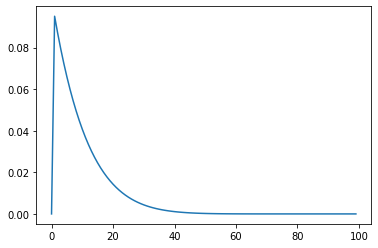

In [13]:

def pmf_cdf(lt):
    
    pmf = np.empty(grid)
    
    
    for i, h in enumerate(hvals):
        if(i == 0):
            pmf[i] = cdf(hvals[i], lt)
        else:
            pmf[i] = cdf(hvals[i], lt) - cdf(hvals[i-1], lt)
        
    return pmf


#test
np.sum(pmf_cdf(0.01))

pmf_cdf(0.02)
plt.plot(pmf_cdf(0.01))
    
np.sum(np.round(pmf_cdf(0.01), 19))






array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 

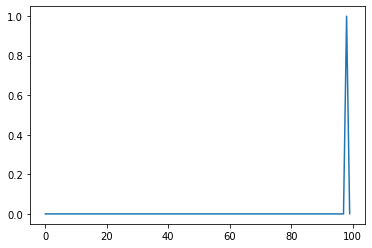

In [14]:
#nova versão da função pmf: agora cada ponto do grid é o centro da cdf
def pmf_cdf(lt, δ = hlow/2):
    
    pmf = np.empty(grid)
    
    
    for i, h in enumerate(hvals):
        pmf[i] = cdf(h+δ, lt) - cdf(h-δ, lt)
        
    return pmf


lt = 0.99
pmf_cdf(lt)
plt.plot(pmf_cdf(lt))

In [15]:
#gerando as pmfs

#probability mass function
pmf = np.empty((grid,grid))


for t, θt in enumerate(hvals):
    pmf[t,:] = pmf_cdf(θt)
    
#precisamos de uma pmf para quando temos lkt e queremos saber θk,t+1
#chamaremos de pmf2
pmf2 = np.empty((grid, grid))

for i in range(len(hvals)):
    for j in range(len(hvals)):
        pmf2[i, j] = np.sum(pmf[i, :] * pmf[:, j])


Arrays dos valores de continuação dos jogadores

In [16]:
#continuation values
#period, θkt, ℓkt, ℓmt
s_W = np.zeros((T, grid, grid, grid))
j_W = np.copy(s_W)


#optimal payments
#period, θkt, ℓmt, outputs
Pst_array = np.zeros((T, grid, grid, 6))
Pjt_array = np.copy(Pst_array)

In [17]:
#populating the last period with the liquidation values
s_W[(T-1), ...] = s_L(T)
j_W[(T-1), ...] = j_L(T)

Funções para calcular os valores de continuação dos jogadores

In [18]:
#função para mapear os valores das habilidades aos arrays
@njit
def find(h):
    
    return np.searchsorted(hvals, h)

find(hvals[7])
type(find(hvals[7]))

find(hvals)

#checando se temos valores repetidos
count = np.bincount(find(hvals))
np.where(count > 1)

7

int

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

(array([], dtype=int64),)

In [19]:
#array to tell us the size of the pie on next period
#arguments: (period, θk,t+1)
U = np.zeros((T, grid))

U = (hvals[:,None] * V[None,:] - C).T


#test
U[1,0] == hvals[0] * V[1] - Ct(1)


U[2,5] == hvals[5] * V[2] - Ct(2)

True

True

In [20]:
#função cutoff

@njit
def cutoff_m(t, Pkt, hkt, lmt, m_W):
    
    cmt = find(lmt)
    
    while(Pkt > m_W[t, cmt, cmt, find(hkt)] and hvals[cmt] < hhigh):
        cmt += 1
            
    
    #returns the index of the cutoff
    return max(int32(cmt), find(lmt))


cutoff_m(T-1, 0.01, 0.5, 0.4, j_W)

99

In [21]:
#function to select the correct pmf function given the cutoff


def h_m(cutoff_m, lmt):
    #takes the indexes of cutoff and lmt
    #if cutoff > lmt, pmf[cutoff]
    #otherwise, pmf2[lmt]
    
    if(cutoff_m > lmt):
        return pmf[cutoff_m, lmt:] #'lmt:' is to make sure the dimensions are ok
    
    else:
        return pmf2[lmt, lmt:]
    

#test
h_m(49,50) == pmf2[50, 50:]
h_m(99, 50) == pmf[99, 50:]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [22]:
#função payoff ótimo

#retorna a política ótima também
#possible shares of the pie
share = np.arange(0, 1.0, step = 0.01)

#falta checar de novo as dimensões
def Pkt(t, hkt, lmt, k_W, m_W, k_L):
    
    #grid of payments is the possible continuation values of the opponent
#     Pkt_grid = m_W[t, find(lmt):, find(lmt), find(hkt)]

    #new grid of payments is the share of the pie tomorrow based on the hability today
    Pkt_grid = np.empty(share.size + 1)
    
    #the first possible value is -Vmax, which is an offer so low that will be rejected for sure (waiting offer)
    Pkt_grid[0] = -Vmax
    
    #the other values are the shares of the pie
    Pkt_grid[1:] = share * U[t, find(hkt)]
    
    
    cutoffs = int32(np.empty(Pkt_grid.shape))
    
    #loop for calculating the cutoffs
    for i, Pkt in enumerate(Pkt_grid):
        cutoffs[i] = cutoff_m(t, Pkt, hkt, lmt, m_W)
    
#     breakpoint()

    #cálculo de E1####
    
    #pE1[3,6] is the third possible payment combined with the sixth hability above hkt

    pE1 = np.array(U[t, None, find(hkt):] - Pkt_grid[:, None])
    
    
    #array com as probabilidades
    #probabiilidades de k amanhã dado a habilidade verdadeira hoje
    probk = pmf[find(hkt),find(hkt):]

    #probabilidade de m amanhã, dado o lower bound hoje
    probm = pmf2[find(lmt), find(lmt):]

    #tipo de produto de kronecker do wikipedia
    #exemplo didático
    # c = np.array([[1], [2]])
    # d = np.array([[1,2], [3,4]])

    # c
    # d

    # np.outer(c,d)

    prob = np.outer(probk,probm)
    
    #multiplicando pE1 pelo array de probabilidades
    pE1 = np.dot(pE1, prob)

    #array indicador
    IE1 = np.where(m_W[t, find(lmt):, cutoffs, find(hkt)] <= Pkt_grid[:,None] , 1, 0)

    #payoff de E1
    E1 = np.multiply(pE1, IE1)
    
    #soma ao longo das colunas (axis = 1) para que cada linha tenha o payoff esperado de propor um pagamento aceitável
    E1 = np.sum(E1, axis = 1)
    
    
    # #cálculo de E2####

    pE2 = k_W[t, find(hkt):, find(hkt), cutoffs]
    
    #multiplicando pE2 pelo array de probabilidades
    pE2 = np.dot(pE2, prob)
    
    #array indicador de 
    IE2 = np.where(IE1 == 1, 0, 1)

    
    #payoff
    E2 = np.multiply(pE2, IE2)
    E2 = np.sum(E2, axis = 1)

    #matriz dos payoffs####
    matrix_payoff = E1 + E2

    payoff_reorg = np.max(matrix_payoff)
    index = np.argmax(matrix_payoff)

    pagamento = Pkt_grid[index]
    
    
    #calculating the optimal policy between liquidating, reorganizing or waiting ####
    payoff_liq = k_L(t)
    
    
    
    #waiting payoff is associated with the first possible payment, which is -Vmax, the waiting offer
    payoff_wait = matrix_payoff[0]
    
    
    
#     #avoiding numerical precision issues when comparing payoffs
#     if(np.allclose(payoff_wait, payoff_reorg, atol = 1e-15)):
#         #if the difference between waiting and reorganization payoff is small, then we use waiting payoff
#         payoff_max = np.max((payoff_liq, payoff_liq, payoff_reorg))
#         policy = np.argmax((payoff_liq, payoff_liq, payoff_reorg))
#     else:
#         payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
#         policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))

    
    
    payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
    policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))
                         
    #retorna o payoff de esperar também para facilitar a verificação do código
    return pagamento, cutoffs[index], payoff_reorg, payoff_wait, payoff_max, policy
        

t, hkt, lmt, k_W, m_W, k_L = T-1, 0.5, 0.6, s_W, j_W, s_L
# share * U[t, find(hkt)]

Pkt(t, hkt, lmt, k_W, m_W, k_L)



(0.0, 59, 0.2009452145111205, 0.19393000000000019, 0.20338, 0)

In [23]:
#função payoff ótimo

#retorna a política ótima também
#possible shares of the pie
share = np.arange(0, 1.0, step = 0.01)

#Pkt2
def Pkt(t, hkt, lmt, k_W, m_W, k_L):
    
    #grid of payments is the possible continuation values of the opponent
#     Pkt_grid = m_W[t, find(lmt):, find(lmt), find(hkt)]

    

    #new grid of payments is the share of the pie tomorrow based on the hability today
    Pkt_grid = np.empty(hvals[find(lmt):].size + 1)
    
    #the first possible value is -Vmax, which is an offer so low that will be rejected for sure (waiting offer)
    Pkt_grid[0] = -Vmax
    
    #the other values are the continuation values of opponent
    Pkt_grid[1:] = m_W[t, find(lmt):, find(lmt), find(hkt)]
    
    
    cutoffs = int32(np.empty(Pkt_grid.shape))
    
    #loop for calculating the cutoffs
    for i, Pkt in enumerate(Pkt_grid):
        cutoffs[i] = cutoff_m(t, Pkt, hkt, lmt, m_W)
    
#     breakpoint()

    #cálculo de E1####
    
    #pE1[3,6] is the third possible payment combined with the sixth hability above hkt

    pE1 = np.array(U[t, None, find(hkt):] - Pkt_grid[:, None])
    
    
    #array com as probabilidades
    #probabiilidades de k amanhã dado a habilidade verdadeira hoje
    probk = pmf[find(hkt),find(hkt):]

    #probabilidade de m amanhã, dado o lower bound hoje ou o cutoff hoje
    
#     #shape is Pkt x M
#     probm = np.empty((Pkt_grid.size, hvals[find(lmt):].size))

#     for i in range(Pkt_grid.size):
#         probm[i] = h_m(cutoffs[i], find(lmt))

    
    
#     #multiplicando pE1 pelas probabilides das habilidades de k
#     pE1 = np.multiply(pE1, probk.T)
#     pE1 = np.sum(pE1, axis = 1)
    
#     #multiplicando agora pelas probabilidades das habilidades de m, dado cada Pkt
#     pE1 = np.multiply(pE1[:, None], probm)



    #ponderação pelas probabilidades
    probk = pmf[find(hkt), find(hkt):]
    probm = pmf[find(lmt), find(lmt):]
    
    prob = np.outer(probk, probm)
    
    pE1 = np.dot(pE1, prob)
    
    #array indicador
    IE1 = np.where(m_W[t, find(lmt):, cutoffs, find(hkt)] <= Pkt_grid[:,None] , 1, 0)
    
    
#     breakpoint()

    #payoff de E1
    E1 = np.multiply(pE1, IE1)
    
    #soma ao longo das colunas (axis = 1) para que cada linha tenha o payoff esperado de propor um pagamento aceitável
    E1 = np.sum(E1, axis = 1)
    
    
    # #cálculo de E2####

    pE2 = k_W[t, find(hkt):, find(hkt), cutoffs]
    
    #multiplicando pE2 pelo array de probabilidades
    pE2 = np.dot(pE2, prob)
    
    #multiplicando pelas probabilides das habilidades de k
#     pE2 = np.multiply(pE2, probk.T)
#     pE2 = np.sum(pE2, axis = 1)
    
#     #multiplicando agora pelas probabilidades das habilidades de m, dado cada Pkt
#     pE2 = np.multiply(pE2[:, None], probm)
    
    
    
    #array indicador de 
    IE2 = np.where(IE1 == 1, 0, 1)

    
    #payoff
    E2 = np.multiply(pE2, IE2)
    E2 = np.sum(E2, axis = 1)

    #matriz dos payoffs####
    matrix_payoff = E1 + E2

    payoff_reorg = np.max(matrix_payoff)
    index = np.argmax(matrix_payoff)

    pagamento = Pkt_grid[index]
    
    
    #calculating the optimal policy between liquidating, reorganizing or waiting ####
    payoff_liq = k_L(t)
    
    
    
    #waiting payoff is associated with the first possible payment, which is -Vmax, the waiting offer
    payoff_wait = matrix_payoff[0]
    
    
    
#     #avoiding numerical precision issues when comparing payoffs
#     if(np.allclose(payoff_wait, payoff_reorg, atol = 1e-15)):
#         #if the difference between waiting and reorganization payoff is small, then we use waiting payoff
#         payoff_max = np.max((payoff_liq, payoff_liq, payoff_reorg))
#         policy = np.argmax((payoff_liq, payoff_liq, payoff_reorg))
#     else:
#         payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
#         policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))

    
    
    payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
    policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))
                         
    #retorna o payoff de esperar também para facilitar a verificação do código
    return pagamento, cutoffs[index], payoff_reorg, payoff_wait, payoff_max, policy
        

t, hkt, lmt, k_W, m_W, k_L = T-1, 0.5, 0.6, s_W, j_W, s_L
# share * U[t, find(hkt)]

Pkt(t, hkt, lmt, k_W, m_W, k_L)



(0.0, 59, 0.2009452145111204, 0.1939300000000001, 0.20338, 0)

In [24]:
def Pst(t, θst, ℓjt):
    return Pkt(t, θst, ℓjt, s_W, j_W, s_L)


def Pjt(t, θjt, ℓst):
    return Pkt(t, θjt, ℓst, j_W, s_W, j_L)

In [25]:
#populando as matrizes para continuar os testes

for h in hvals:
    for l in hvals:
            Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
            Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)

In [26]:
#checando se populou ok
t, h, l = T-1, 0.5, 0.5
Pst_array[t, find(h), find(l),:] == Pst(t, h, l)

array([ True,  True,  True,  True,  True,  True])

In [27]:
#função da proposta ótima


def propose(t, hkt, lkt, lmt, Pkt_array):
    #apenas busca o valor de Pkt
    
    payoff_max, policy = Pkt_array[t, find(hkt), find(lmt)][-2:]
    
    return payoff_max, policy

#test


t, hkt, lkt, lmt, Pkt_array = T-1, 0.5, 0.01, 0.5, Pst_array

Pst_array[t, find(hkt), find(lmt), :] = Pkt(t, hkt, lmt, k_W, m_W, k_L)

propose(t, hkt, lkt, lmt, Pkt_array)


(0.20338, 0.0)

In [28]:
#função de threshold

def threshold_m(t, lkt, lmt, Pmt_array):
    
    #procura onde a última entrada é diferente de 0 (policy de liquidar a firma)
    threshold_vector = np.array(np.where(Pmt_array[t, :, find(lkt), -1] != 0.0))
    
    if(threshold_vector.size == 0):
        #threshold does not exist
        ts = hhigh #will update lower bound to 1 just to accelerate the calculations
        probm_liq = 1.0
        
    else:
        ts = hvals[np.min(threshold_vector)]
    
        #probability that m will propose liquidation next period
        if(lmt >= ts):
            probm_liq = 0.0
        else:
            probm_liq = cdf(ts,lmt)
        
    #returns the reorganization threshold and the probability that m will propose liquidation in t
    return ts, probm_liq
    
    
 
t, lkt,lmt, Pmt_array = T-1, 0.5,0.51, Pst_array

Pmt_array[t, :, find(lkt), -1]

threshold_m(t, lkt,lmt,  Pmt_array)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

(0.51, 0.0)

In [29]:
#payoff esperado de responder a uma proposta de reorganização

def respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W):
    ts, probm_liq = threshold_m(t, lkt, lmt, Pmt_array)
    
    lmt = max(ts, lmt)
    
    
    #the possible values of payment given by the opponent
    Pmt_grid = Pmt_array[t, find(lmt):, find(lkt), 0]
    cutoffs = Pmt_array[t, find(lmt):, find(lkt), 1]
    cutoffs = int32(cutoffs)


    #A1### 
    
    #payoff quando receber pagamento é melhor respota
    pA1 = Pmt_grid

    #ponderação pelas probabilidades
    probk = pmf[find(hkt), find(hkt):]
    probm = pmf[find(lmt), find(lmt):]


    #primeiro vamos ver a função indicadora
    IA1 = np.where(k_W[t, find(hkt):, cutoffs, np.arange(find(lmt), grid, step = 1)].T <= Pmt_grid, 1, 0)

    #IA1 tem S linhas e J colunas

    #queremos uma matriz de probabiidades com a mesma dimensão
    prob = np.outer(probk, probm)

    pA1 = np.multiply(pA1.T, prob)

    A1 = np.multiply(pA1, IA1)

    #A2####

    IA2 = np.where(IA1 == 1, 0, 1)

    pA2 = k_W[t, find(hkt):, cutoffs, np.arange(find(lmt), grid, step = 1)].T

    pA2 = np.multiply(pA2, prob)

    A2 = np.multiply(pA2, IA2)

    payoff = A1 + A2
    payoff = np.sum(payoff)

    #returns the expected value of answering a reorganization proposal and the probability of liquidation
    return payoff * (1.0 -probm_liq), probm_liq

#test1
t, hkt, lkt, lmt, Pmt_array, k_W = T-1, 0.5, 0.5, 0.5, Pjt_array, s_W
respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)


lmt, probm_liq = threshold_m(t, lkt, lmt, Pmt_array)
Pjt(t, lmt, lkt)


#test2
t, hkt, lkt, lmt, Pmt_array, k_W = T-1, 0.5, 0.5, 0.5, Pst_array, j_W
respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)

Pst(t, lmt, lkt)


(0.1939300000000002, 0.0)

(0.19393, 49, 0.0029003889749073778, 0.0, 0.0029003889749073778, 2)

(0.0, 0.18028178662206829)

(0.0, 49, 0.20094521451112046, 0.19393000000000019, 0.20338, 0)

In [30]:
ts, probm_liq = threshold_m(t, lkt, lmt, Pmt_array)
    
lmt = max(ts, lmt)


#the possible values of payment given by the opponent
Pmt_grid = Pmt_array[t, find(lmt):, find(lkt), 0]
cutoffs = Pmt_array[t, find(lmt):, find(lkt), 1]
cutoffs = int32(cutoffs)


#A1### 

#payoff quando receber pagamento é melhor respota
pA1 = Pmt_grid

#ponderação pelas probabilidades
probk = pmf[find(hkt), find(hkt):]
probm = pmf[find(lmt), find(lmt):]


#primeiro vamos ver a função indicadora
IA1 = np.where(k_W[t, find(hkt):, cutoffs, np.arange(find(lmt), grid, step = 1)].T <= Pmt_grid, 1, 0)

#IA1 tem S linhas e J colunas

#queremos uma matriz de probabiidades com a mesma dimensão
prob = np.outer(probk, probm)

In [31]:
prob.shape

probk.shape

IA1.shape
pA1.shape

(51, 50)

(51,)

(51, 50)

(50,)

In [32]:
#payoff esperado de responder a uma proposta de liquidação

def respond_liq(t, hkt, lkt, lmt, k_L, m_L):
    
    #reorganiza pagando o valor de liquidação do oponente
    payoff_reorg = np.dot(pmf[find(hkt), find(hkt):], U[t, find(hkt):] - m_L(t))
    
    payoff_liq = k_L(t)
    
    return max(payoff_liq, payoff_reorg)

t, hkt, lkt, lmt, k_L, m_L = T-1, 0.5, 0.5, 0.5, s_L, j_L

respond_liq(t, hkt, lkt, lmt, k_L, m_L)
np.dot(pmf[find(hkt), find(hkt):], U[t, find(hkt):] - m_L(t))
k_L(t)

0.20338

0.20094521451112035

0.20338

In [33]:
#payoff esperado de responder
def respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L):
    
    payoff_rreorg, probm_liq = respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)
    
    return payoff_rreorg + probm_liq * respond_liq(t, hkt, lkt, lmt, k_L, m_L)
    
t, hkt, lkt, lmt, k_L, m_L, Pmt_array, k_W = T-1, 0.5, 0.5, 0.5, s_L, j_L, Pst_array, j_W

respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L)


0.03666570976319625

In [34]:
#funções de s baseado nas funções genéricas
def Pst(t, θst, ℓjt):
    return Pkt(t, θst, ℓjt, s_W, j_W, s_L)

def s_propose(t, θst, ℓst, ℓjt):
    return propose(t, θst, ℓst, ℓjt, Pst_array)

def threshold_j(t, ℓst, ℓjt):
    return threshold_m(t, ℓst, ℓjt, Pjt_array)

def s_respond_reorg(t, θst, ℓst, ℓjt):
    return respond_reorg(t, θst, ℓst, ℓjt, Pjt_array, s_W)

def s_respond_liq(t, θst, ℓst, ℓjt):
    return respond_liq(t, θst, ℓst, ℓjt, s_L, j_L)
    
def s_respond(t, θst, ℓst, ℓjt):
    return respond(t, θst, ℓst, ℓjt, Pjt_array, s_W, s_L, j_L)


In [35]:
#funções de j baseado nas funções genéricas
def Pjt(t, θjt, ℓst):
    return Pkt(t, θjt, ℓst, j_W, s_W, j_L)

def j_propose(t, θjt, ℓjt, ℓst):
    return propose(t, θjt, ℓjt, ℓst, Pjt_array)

def threshold_s(t, ℓjt, ℓst):
    return threshold_m(t, ℓjt, ℓst, Pst_array)

def j_respond_reorg(t, θjt, ℓjt, ℓst):
    return respond_reorg(t, θjt, ℓjt, ℓst, Pst_array, j_W)

def j_respond_liq(t, θjt, ℓjt, ℓst):
    return respond_liq(t, θjt, ℓjt, ℓst, j_L, s_L)
    
def j_respond(t, θjt, ℓjt, ℓst):
    return respond(t, θjt, ℓjt, ℓst, Pst_array, j_W, j_L, s_L)

### Populando as matrizes do jogo

##### 1,2,3 Testando

In [36]:
t = (T-1)


start = time.process_time()

#populando as matrizes para continuar os testes

for h in hvals:
    for l in hvals:
            Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
            Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)
            

duração = time.process_time() - start



print("tempo total para popular o período", t, ":",time.process_time() - start)

tempo total para popular o período 2 : 11.90625


In [37]:
#testando funções
t, hkt, lkt, lmt = T-1, 0.6, 0.4, 0.5



In [38]:
s_propose(t, hkt, lkt, lmt)


threshold_j(t, ℓkt, ℓmt)
np.where(Pjt_array[t, :, find(lkt), -1] == 2)
#ok
print('respond_reorg')
s_respond_reorg(t, hkt, lkt, lmt)

#ok, e nesse caso s prefere liquidar a firma mesmo
s_respond_liq(t, hkt, lkt, lmt)
s_L(t)


#ok
s_respond(t, hkt, lkt, lmt)


#teste

s_respond(t, hkt, lkt, lmt) == s_respond_reorg(t, hkt, lkt, lmt)[0] + s_respond_reorg(t, hkt, lkt, lmt)[1] * s_respond_liq(t, hkt, lkt, lmt)

(0.24209147652152113, 2.0)

(0.49, 0.0)

(array([48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,
        99], dtype=int64),)

respond_reorg


(0.19393000000000013, 0.0)

0.24209147652152102

0.20338

0.19393000000000013

True

In [39]:
j_propose(t, hkt, lkt, lmt)


#o threshold de ambos é para dar igual mesmo?
threshold_s(t, ℓkt, ℓmt)
np.where(Pst_array[t, :, find(lkt), -1] == 2)
#ok
print('respond_reorg')
j_respond_reorg(t, hkt, lkt, lmt)

#ok, e nesse caso s prefere liquidar a firma mesmo
j_respond_liq(t, hkt, lkt, lmt)
j_L(t)


#ok
j_respond(t, hkt, lkt, lmt)

#teste

j_respond(t, hkt, lkt, lmt) == j_respond_reorg(t, hkt, lkt, lmt)[0] + j_respond_reorg(t, hkt, lkt, lmt)[1] * j_respond_liq(t, hkt, lkt, lmt)

(0.048161476521521036, 2.0)

(0.51, 0.18028178662206829)

(array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int64),)

respond_reorg


(0.0, 0.18028178662206829)

0.03871147652152099

0.0

0.006978974150078053

True

#### Populando todos os períodos

In [40]:


for t in range(T-1, 0, -1):

    start = time.process_time()

    #populando as matrizes para continuar os testes

    for h in hvals:
        for l in hvals:
                Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
                Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)
    print("tempo total para preparar o terreno do período", t, ":", time.process_time() - start)
    
    
    
    for i, hk in enumerate(hvals):
        for j, lk in enumerate(hvals):
            for k, lm in enumerate(hvals):
                s_W[(t-1), i, j, k] = λj * s_respond(t, hk, lk, lm) + (1-λj) * s_propose(t, hk, lk, lm)[0]
                j_W[(t-1), i, j, k] = λj * j_propose(t, hk, lk, lm)[0] + (1-λj) * j_respond(t, hk, lk, lm)


    duração = time.process_time() - start



    print("tempo total para popular o período", t, ":",time.process_time() - start)

tempo total para preparar o terreno do período 2 : 10.40625
tempo total para popular o período 2 : 266.953125
tempo total para preparar o terreno do período 1 : 11.59375
tempo total para popular o período 1 : 284.046875


In [41]:
#preparando o terreno no período 0 
t = 0

for h in hvals:
        for l in hvals:
                Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
                Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)

In [42]:
#testando funções
t, hkt, lkt, lmt = 0, 0.6, 0.4, 0.5

Pst(t, hkt, lmt)
Pjt(t, hkt, lmt)

(0.12241376344283177,
 57,
 0.5038067354204304,
 0.46628342043179544,
 0.5038067354204304,
 2)

(0.41645790795464255,
 56,
 0.20106636282568893,
 0.14904996329390338,
 0.20106636282568893,
 2)

Salvando os dados

In [43]:
import os.path
date = '22_10'

np.save(os.path.join('Ws_array_'+date), s_W)
np.save(os.path.join('Wj_array_'+date), j_W)
np.save(os.path.join('Pst_array_'+date), Pst_array)
np.save(os.path.join('Pjt_array_'+date), Pjt_array)


Carregando os dados

#dia 17_10 foi o último dia com dados errados, ρ = 0.9xxx. Antes de corrigir o threshold
#dia 19_10 foi quando consertei o threshold, ρ = 0.5

import os.path
date = '19_10'

s_W = np.load(os.path.join('Ws_array_'+date+'.npy'))
j_W = np.load(os.path.join('Wj_array_'+date+'.npy'))
Pst_array = np.load(os.path.join('Pst_array_'+date+'.npy'))
Pjt_array = np.load(os.path.join('Pjt_array_'+date+'.npy'))


### Gráfico das funções

Gráfico das funções propose e respond

In [44]:
def graf_func(θ_vector, t, creditor,  function, ℓkt, ℓmt):
    #true hability increases while lower bounds stay at 0.5
    #t is also endogenous 
    
    fig, ax = plt.subplots()

    #size of X axis
    X = θ_vector


    #storing the function vals in t
    graf_vals = []

    for θt in θ_vector:
        function_val = function(t, θt, ℓkt, ℓmt)
        
        #for when we use the propose method, which returns a vector
        if(np.isscalar(function_val) == False):
            function_val = function_val[0]
            

        graf_vals.append(function_val)
        
        
#     label_val = repr(function)
    title_val = print(function, 'ℓkt = ', ℓkt, 'ℓmt = ', ℓmt)

    ax.plot(X, graf_vals, '-k', linewidth = 3, alpha = 0.8)


    # ax.yaxis.tick_right()
    # ax.yaxis.set_ticks_position('both')

    #para mostrar ticks dos dois lados do eixo y



    plt.xlabel("θt")
    plt.ylabel("Value of the function")

    ax.set_title(title_val)

    #achei melhor no upper right
    ax.legend(loc = 'upper center')
    plt.show()

No handles with labels found to put in legend.


<function s_propose at 0x000002D59A02E558> ℓkt =  0.5 ℓmt =  0.5


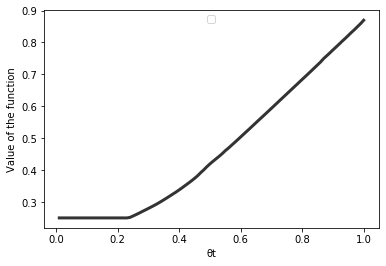

No handles with labels found to put in legend.


<function s_propose at 0x000002D59A02E558> ℓkt =  0.3 ℓmt =  0.9


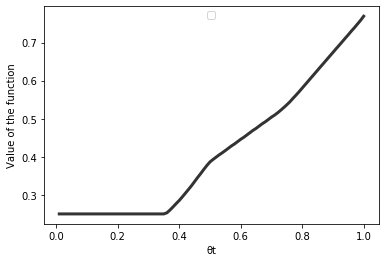

In [45]:
graf_func(hvals, 0, 's', s_propose, ℓkt = 0.5, ℓmt = 0.5)
graf_func(hvals, 0 , 's', s_propose, ℓkt = 0.3, ℓmt = 0.9)

No handles with labels found to put in legend.


<function s_respond at 0x000002D5BBF894C8> ℓkt =  0.5 ℓmt =  0.5


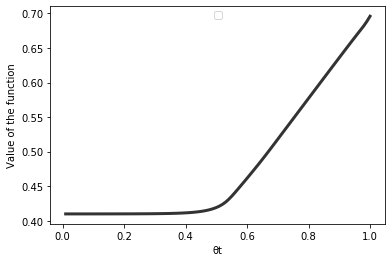

No handles with labels found to put in legend.


<function s_respond at 0x000002D5BBF894C8> ℓkt =  0.3 ℓmt =  0.9


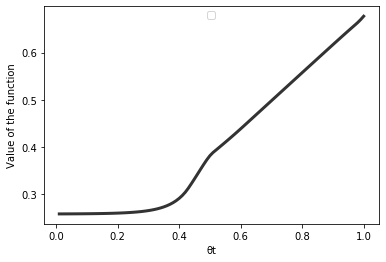

In [46]:
graf_func(hvals, 0, 's', s_respond, ℓkt = 0.5, ℓmt = 0.5)
graf_func(hvals, 0 , 's', s_respond, ℓkt = 0.3, ℓmt = 0.9)

Gráfico do valor de continuação

No handles with labels found to put in legend.


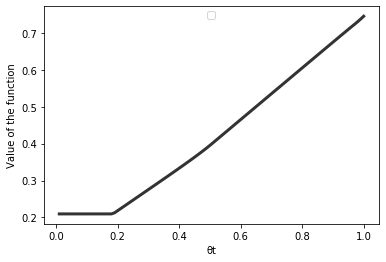

No handles with labels found to put in legend.


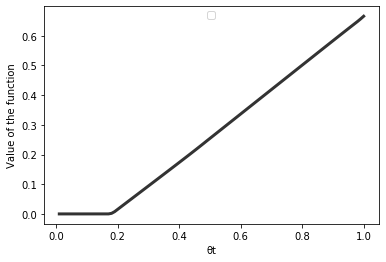

In [47]:
def graf_func_value(k_array, ℓkt, ℓmt, t):
    #t starts at t=1
    
    fig, ax = plt.subplots()

    #size of X axis
    X = hvals


    #storing the function vals in t
    graf_vals = k_array[(t-1), :, find(ℓkt), find(ℓmt)]


    ax.plot(X, graf_vals, '-k', linewidth = 3, alpha = 0.8)
    
#     name = str(k_array)
#     title_val = print(name, 'ℓkt = ', ℓkt, 'ℓmt = ', ℓmt, 'period = ', t)


    # ax.yaxis.tick_right()
    # ax.yaxis.set_ticks_position('both')

    #para mostrar ticks dos dois lados do eixo y



    plt.xlabel("θt")
    plt.ylabel("Value of the function")


    #achei melhor no upper right
    ax.legend(loc = 'upper center')
    plt.show()
    
graf_func_value(s_W, ℓkt = 0.01, ℓmt = 0.02, t = 1)

graf_func_value(j_W, ℓkt = 0.01, ℓmt = 0.02, t = 1)

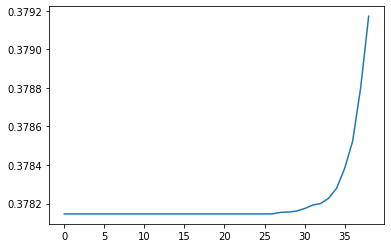

In [48]:
#checando se função valor é crescente no lower bound
t = 0
hk = 0.5
lm = 0.4


graf = np.empty(len(hvals[:find(lm)]))


for i in range(find(0.01), find(lm)):
    graf[i] = s_W[t, find(hk), find(hvals[i]), find(lm)]
    
    
plt.plot(graf)

#é crescente (não estritamente)

Gráfico das propostas ótimas

In [49]:

def graf_proposal(function, function_name, t, xlabel, ylabel):
    

    grid_graf = len(hvals)

    graf = np.empty((grid_graf, grid_graf))

    for i, θs in enumerate(hvals):
        for j, lj in enumerate(hvals):
            graf[i,j] = function(t, θs, θs, lj)[1]


    fig, ax = plt.subplots()

    cs1 = ax.contourf(hvals, hvals, graf.T, alpha=0.75)
    # ctr1 = ax.contour(hvals, lj_vals, graf1.T)
    # plt.clabel(ctr1, inline=1, fontsize=13)
    plt.colorbar(cs1, ax = ax)

    ax.set_title('Function ' + function_name +   ' in period ' + str(t) )
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

    ax.ticklabel_format(useOffset=False)


    plt.show()

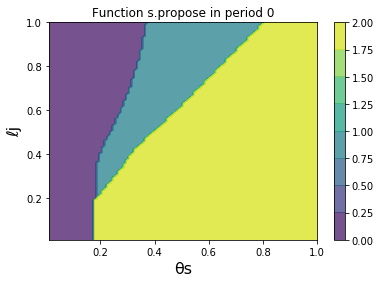

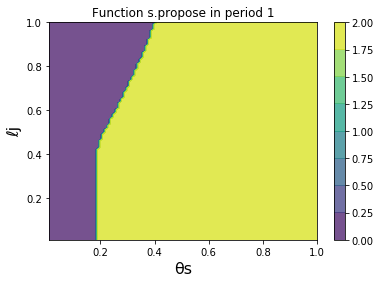

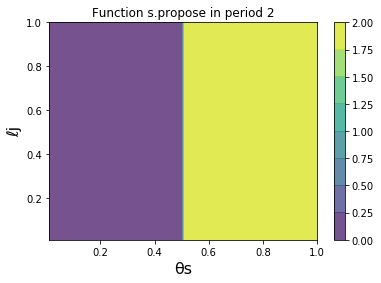

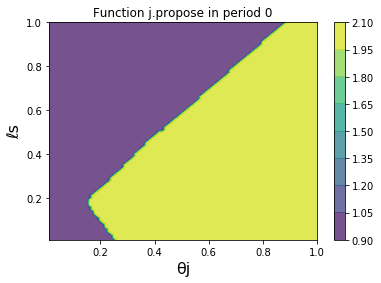

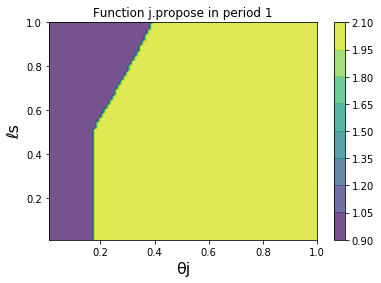

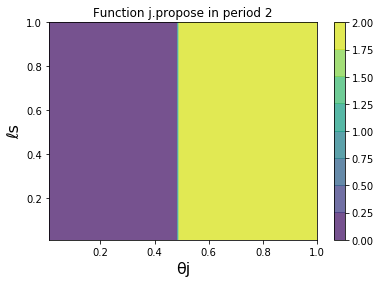

In [62]:
graf_proposal(s_propose,'s.propose', 0, 'θs', 'ℓj')

graf_proposal(s_propose,'s.propose', 1, 'θs', 'ℓj')

graf_proposal(s_propose,'s.propose', 2, 'θs', 'ℓj')

graf_proposal(j_propose, 'j.propose', 0, 'θj', 'ℓs')
graf_proposal(j_propose, 'j.propose', 1, 'θj', 'ℓs')
graf_proposal(j_propose, 'j.propose', 2, 'θj', 'ℓs')

#### Checando função propose nos locais onde ela está estranha

1) j_propose tem uma barriga estranha em t = 0, quando hk está fixo em 0.2

2) j_propose em t = 2 deveria ser sempre reorganizar. Não faz sentido j propor liquidar. (Ou faz?)

In [65]:
#hk variando e lm fixa
t = 2
lm = 0.8

low = 0.4
high = 0.5

# for i in range(find(low), find(high)):
#     Pjt(t, hvals[i], lm )[2] - Pjt(t, hvals[i], lm )[3], Pjt(0, hvals[i], lm )[-1], i
    
    
for i in range(find(low), find(high)):
    Pjt(t, hvals[i], lm ), i

((-1.0, 79, 0.0, 0.0, 0.0, 0), 39)

((-1.0, 79, 0.0, 0.0, 0.0, 0), 40)

((-1.0, 79, 0.0, 0.0, 0.0, 0), 41)

((-1.0, 79, 0.0, 0.0, 0.0, 0), 42)

((-1.0, 79, 0.0, 0.0, 0.0, 0), 43)

((-1.0, 79, 0.0, 0.0, 0.0, 0), 44)

((-1.0, 79, 0.0, 0.0, 0.0, 0), 45)

((-1.0, 79, 0.0, 0.0, 0.0, 0), 46)

((-1.0, 79, 0.0, 0.0, 0.0, 0), 47)

((0.19393, 79, 0.002900388974907377, 0.0, 0.002900388974907377, 2), 48)

In [52]:
#hk fixa e lm variando
t = 0
lm = 0.01
hk = 0.61

for i in range(find(0.01), find(0.3)):
    (Pst(t, hk, hvals[i])[2] - Pst(t, hk, hvals[i])[3])/Pst(t, hk, hvals[i])[3], Pst(t, hk, hvals[i] )[-1], i

(0.2734370704204106, 2, 0)

(0.2709992016148902, 2, 1)

(0.26827531211966926, 2, 2)

(0.26522831348227854, 2, 3)

(0.26231179264528837, 2, 4)

(0.2594454047688168, 2, 5)

(0.2562271428733886, 2, 6)

(0.2526092172307919, 2, 7)

(0.24853669894680808, 2, 8)

(0.24394635168700934, 2, 9)

(0.24030804374985532, 2, 10)

(0.23700602335665064, 2, 11)

(0.23352485739856244, 2, 12)

(0.23009440786305077, 2, 13)

(0.2263127274041977, 2, 14)

(0.22201142071427585, 2, 15)

(0.2171111912904306, 2, 16)

(0.21151935559369112, 2, 17)

(0.2073426598759048, 2, 18)

(0.20382347211876634, 2, 19)

(0.2001783295384495, 2, 20)

(0.1965424694568165, 2, 21)

(0.1930468156269253, 2, 22)

(0.18952136362117677, 2, 23)

(0.18586253102739783, 2, 24)

(0.18037835517653067, 2, 25)

(0.17588278305736124, 2, 26)

(0.17117813611955085, 2, 27)

(0.16640025466227118, 2, 28)

2) Quando lm está fixo e hk varia

In [53]:
#hk variando e lm fixa
t = 0
lm = 0.8

low = 0.2
high = 0.5

for i in range(find(low), find(high)):
    Pst(t, hvals[i], lm )[2] - Pst(t, hvals[i], lm )[3], Pst(0, hvals[i], lm )[-1], i

(0.0, 0, 19)

(0.0, 0, 20)

(0.0, 0, 21)

(0.0, 0, 22)

(0.0, 0, 23)

(0.0, 0, 24)

(0.0, 0, 25)

(0.0, 0, 26)

(0.0, 0, 27)

(0.0, 0, 28)

(0.0, 0, 29)

(0.0, 0, 30)

(0.0, 0, 31)

(0.0, 0, 32)

(0.0, 1, 33)

(0.0, 1, 34)

(0.0, 1, 35)

(0.0, 1, 36)

(0.0, 1, 37)

(0.0, 1, 38)

(0.0, 1, 39)

(0.0, 1, 40)

(0.0, 1, 41)

(0.0, 1, 42)

(0.0, 1, 43)

(0.0, 1, 44)

(0.0, 1, 45)

(0.0, 1, 46)

(0.0, 1, 47)

(0.0, 1, 48)

In [54]:
#hk variando e lm fixa

#quero ver os cutoffs agora

t = 0
lm = 0.8
low = 0.01
high = 0.6

for i in range(find(low), find(high)):
    i, Pst(t, hvals[i], lm )

(0, (-1.0, 79, 0.20923579006700563, 0.20923579006700563, 0.25, 0))

(1, (-1.0, 79, 0.20932004890264647, 0.20932004890264647, 0.25, 0))

(2, (-1.0, 79, 0.20941411014864628, 0.20941411014864628, 0.25, 0))

(3, (-1.0, 79, 0.20951923337936332, 0.20951923337936332, 0.25, 0))

(4, (-1.0, 79, 0.20963685567079676, 0.20963685567079676, 0.25, 0))

(5, (-1.0, 79, 0.20976861886878406, 0.20976861886878406, 0.25, 0))

(6, (-1.0, 79, 0.20991640140025655, 0.20991640140025655, 0.25, 0))

(7, (-1.0, 79, 0.21008235544477633, 0.21008235544477633, 0.25, 0))

(8, (-1.0, 79, 0.21026895044168278, 0.21026895044168278, 0.25, 0))

(9, (-1.0, 79, 0.21047902409906913, 0.21047902409906913, 0.25, 0))

(10, (-1.0, 79, 0.21071584230174098, 0.21071584230174098, 0.25, 0))

(11, (-1.0, 79, 0.21098316959528302, 0.21098316959528302, 0.25, 0))

(12, (-1.0, 79, 0.21128535226347855, 0.21128535226347855, 0.25, 0))

(13, (-1.0, 79, 0.21162741643041896, 0.21162741643041896, 0.25, 0))

(14, (-1.0, 79, 0.21201518412390985, 0.21201518412390985, 0.25, 0))

(15, (-1.0, 79, 0.21245541085468783, 0.21245541085468783, 0.25, 0))

(16, (-1.0, 79, 0.2129559490233529, 0.2129559490233529, 0.25, 0))

(17, (-1.0, 79, 0.21352594239751677, 0.21352594239751677, 0.25, 0))

(18, (-1.0, 79, 0.21417605804777853, 0.21417605804777853, 0.25, 0))

(19, (-1.0, 79, 0.21491876354623932, 0.21491876354623932, 0.25, 0))

(20, (-1.0, 79, 0.2157686589828671, 0.2157686589828671, 0.25, 0))

(21, (-1.0, 79, 0.2167428755288106, 0.2167428755288106, 0.25, 0))

(22, (-1.0, 79, 0.21786155498064735, 0.21786155498064735, 0.25, 0))

(23, (-1.0, 79, 0.21914842809450835, 0.21914842809450835, 0.25, 0))

(24, (-1.0, 79, 0.22063151374180504, 0.22063151374180504, 0.25, 0))

(25, (-1.0, 79, 0.22234397162063607, 0.22234397162063607, 0.25, 0))

(26, (-1.0, 79, 0.22454082375655612, 0.22454082375655612, 0.25, 0))

(27, (-1.0, 79, 0.2269317198215207, 0.2269317198215207, 0.25, 0))

(28, (-1.0, 79, 0.22959485822880973, 0.22959485822880973, 0.25, 0))

(29, (-1.0, 79, 0.2328421644268905, 0.2328421644268905, 0.25, 0))

(30, (-1.0, 79, 0.23715424296304377, 0.23715424296304377, 0.25, 0))

(31, (-1.0, 79, 0.24215825771568608, 0.24215825771568608, 0.25, 0))

(32, (-1.0, 79, 0.24771539643409982, 0.24771539643409982, 0.25, 0))

(33,
 (-1.0, 79, 0.25365841601815536, 0.25365841601815536, 0.25365841601815536, 1))

(34,
 (-1.0, 79, 0.26048857460556313, 0.26048857460556313, 0.26048857460556313, 1))

(35,
 (-1.0, 79, 0.26770727324012844, 0.26770727324012844, 0.26770727324012844, 1))

(36, (-1.0, 79, 0.275019186394513, 0.275019186394513, 0.275019186394513, 1))

(37,
 (-1.0, 79, 0.28222516355409805, 0.28222516355409805, 0.28222516355409805, 1))

(38, (-1.0, 79, 0.2902259054477457, 0.2902259054477457, 0.2902259054477457, 1))

(39, (-1.0, 79, 0.2985767916577106, 0.2985767916577106, 0.2985767916577106, 1))

(40, (-1.0, 79, 0.3068067624700525, 0.3068067624700525, 0.3068067624700525, 1))

(41, (-1.0, 79, 0.3154546571773597, 0.3154546571773597, 0.3154546571773597, 1))

(42,
 (-1.0, 79, 0.32473122546871586, 0.32473122546871586, 0.32473122546871586, 1))

(43, (-1.0, 79, 0.334333753292419, 0.334333753292419, 0.334333753292419, 1))

(44,
 (-1.0, 79, 0.34359709116501785, 0.34359709116501785, 0.34359709116501785, 1))

(45,
 (-1.0, 79, 0.35345602490942757, 0.35345602490942757, 0.35345602490942757, 1))

(46,
 (-1.0, 79, 0.36360335096671736, 0.36360335096671736, 0.36360335096671736, 1))

(47,
 (-1.0, 79, 0.37362946597259483, 0.37362946597259483, 0.37362946597259483, 1))

(48, (-1.0, 79, 0.3825269567303141, 0.3825269567303141, 0.3825269567303141, 1))

(49, (-1.0, 79, 0.391119169893168, 0.391119169893168, 0.391119169893168, 1))

(50,
 (-1.0, 79, 0.39824300963328263, 0.39824300963328263, 0.39824300963328263, 1))

(51,
 (-1.0, 79, 0.40411184014394574, 0.40411184014394574, 0.40411184014394574, 1))

(52, (-1.0, 79, 0.4095469830106555, 0.4095469830106555, 0.4095469830106555, 1))

(53, (-1.0, 79, 0.4155661674984068, 0.4155661674984068, 0.4155661674984068, 1))

(54, (-1.0, 79, 0.4216262503620844, 0.4216262503620844, 0.4216262503620844, 1))

(55, (-1.0, 79, 0.4270771668575842, 0.4270771668575842, 0.4270771668575842, 1))

(56,
 (-1.0, 79, 0.43291657031620817, 0.43291657031620817, 0.43291657031620817, 1))

(57, (-1.0, 79, 0.4389771746020985, 0.4389771746020985, 0.4389771746020985, 1))

(58,
 (-1.0, 79, 0.44504394858577584, 0.44504394858577584, 0.44504394858577584, 1))

In [55]:
#hk variando e lm fixa
t = 0
lm = hvals[9]

low = 0.2
high = 0.5

for i in range(find(low), find(high)):
    i,Pst(t, hvals[i], lm )

(19,
 (0.0001368476039748146,
  16,
  0.26799610194565343,
  0.26070326776569963,
  0.26799610194565343,
  2))

(20,
 (0.00013657354125094263,
  16,
  0.2754187954859533,
  0.26591153314173543,
  0.2754187954859533,
  2))

(21,
 (0.00013626656796249107,
  16,
  0.2828436458796832,
  0.2711248471939804,
  0.2828436458796832,
  2))

(22,
 (0.0001359224361538377,
  16,
  0.2902709377134642,
  0.27634387412271044,
  0.2902709377134642,
  2))

(23,
 (0.002000418144159116,
  17,
  0.2978845608488494,
  0.281569370445942,
  0.2978845608488494,
  2))

(24,
 (0.0019961417307780773,
  17,
  0.30550380573055946,
  0.2868021981859924,
  0.30550380573055946,
  2))

(25,
 (0.001991215417692426,
  17,
  0.3131265814566807,
  0.2920433398858634,
  0.3131265814566807,
  2))

(26,
 (0.0019855295837265963,
  17,
  0.32075341950933717,
  0.29729395910619466,
  0.32075341950933717,
  2))

(27,
 (0.0019789542253734207,
  17,
  0.3283860563487486,
  0.30255657966940663,
  0.3283860563487486,
  2))

(28,
 (0.0019713348021421213,
  17,
  0.33602294016930767,
  0.30783032398058185,
  0.33602294016930767,
  2))

(29,
 (0.004900176467060593,
  18,
  0.3438197963863928,
  0.31311843728132166,
  0.3438197963863928,
  2))

(30,
 (0.004874597202091723,
  18,
  0.3516434956161746,
  0.31842348195753356,
  0.3516434956161746,
  2))

(31,
 (0.007751178588777823,
  19,
  0.35949781402860237,
  0.32374774936252027,
  0.35949781402860237,
  2))

(32,
 (0.007695201557442309,
  19,
  0.36750153912457606,
  0.3290924751497107,
  0.36750153912457606,
  2))

(33,
 (0.007629463329188189,
  19,
  0.37552325973708595,
  0.33446485275627463,
  0.37552325973708595,
  2))

(34,
 (0.010386053304843136,
  20,
  0.383609680575866,
  0.33986732419785126,
  0.383609680575866,
  2))

(35,
 (0.010260383750562665,
  20,
  0.39182379582827476,
  0.34529952860311425,
  0.39182379582827476,
  2))

(36,
 (0.010111649144406933,
  20,
  0.4000660815606525,
  0.35076790397747093,
  0.4000660815606525,
  2))

(37,
 (0.012648326735764097,
  21,
  0.40842071323814905,
  0.35627343199016653,
  0.40842071323814905,
  2))

(38,
 (0.012380771737302175,
  21,
  0.416900540315538,
  0.36183521486176057,
  0.416900540315538,
  2))

(39,
 (0.014651215801054615,
  22,
  0.4254382026869882,
  0.3674456577774841,
  0.4254382026869882,
  2))

(40,
 (0.014234819314285191,
  22,
  0.4341703476861729,
  0.37312317424461217,
  0.4341703476861729,
  2))

(41,
 (0.013791927332069406,
  22,
  0.4429337774373626,
  0.3788623958284508,
  0.4429337774373626,
  2))

(42,
 (0.013258605857996089,
  22,
  0.4518078367852253,
  0.3846936731433727,
  0.4518078367852253,
  2))

(43,
 (0.012614293818950757,
  22,
  0.4607831247205911,
  0.3905861889550583,
  0.4607831247205911,
  2))

(44,
 (0.01183325980184909,
  22,
  0.469875232932916,
  0.39655465353697633,
  0.469875232932916,
  2))

(45,
 (0.010927075143567862,
  22,
  0.47909725113340107,
  0.4026182230260301,
  0.47909725113340107,
  2))

(46,
 (0.010061772782008234,
  22,
  0.488270082531846,
  0.408737146010128,
  0.488270082531846,
  2))

(47,
 (0.009221962927692121,
  22,
  0.49743004202973334,
  0.4149240181925885,
  0.49743004202973334,
  2))

(48,
 (0.008363687100840381,
  22,
  0.5066039491685977,
  0.421171446493328,
  0.5066039491685977,
  2))

II) Analisado j_propose em t = 0

1) Checando quando lm = 0.01 e hk varia entre 0.2 e 0.4. 

In [56]:
#hk variando e lm fixa
t = 0
lm = 0.01

low = 0.2
high = 0.4

for i in range(find(low), find(high)):
    Pjt(t, hvals[i], lm )[2] - Pjt(t, hvals[i], lm )[3], Pjt(t, hvals[i], lm )[-1], i

(0.0, 1, 19)

(0.0, 1, 20)

(0.0, 1, 21)

(0.0, 1, 22)

(0.0, 1, 23)

(0.0, 1, 24)

(4.803772274167284e-05, 2, 25)

(0.0001374492251251247, 2, 26)

(0.00022663111062734553, 2, 27)

(0.00031560768647914683, 2, 28)

(0.00040432114097771477, 2, 29)

(0.0004927285903496004, 2, 30)

(0.0005807380726588207, 2, 31)

(0.0006685725225121231, 2, 32)

(0.0007559409942017037, 2, 33)

(0.001026552803276043, 2, 34)

(0.0020396267848106775, 2, 35)

(0.0030525034501018566, 2, 36)

(0.004064574100242885, 2, 37)

(0.00507579657650209, 2, 38)

2) Checando quando ls = 0.8 e hk varia de 0.01 até 0.6

In [57]:
#hk variando e lm fixa
t = 0
lm = 0.8

low = 0.01
high = 0.6

for i in range(find(low), find(high)):
    i, Pjt(t, hvals[i], lm )

(0,
 (-1.0,
  79,
  0.0005517407296049743,
  0.0005517407296049743,
  0.0005517407296049743,
  1))

(1,
 (-1.0,
  79,
  0.0006084468199345746,
  0.0006084468199345746,
  0.0006084468199345746,
  1))

(2,
 (-1.0,
  79,
  0.0006716516465864695,
  0.0006716516465864695,
  0.0006716516465864695,
  1))

(3,
 (-1.0,
  79,
  0.0007421785248396117,
  0.0007421785248396117,
  0.0007421785248396117,
  1))

(4,
 (-1.0,
  79,
  0.0008209652426810292,
  0.0008209652426810292,
  0.0008209652426810292,
  1))

(5,
 (-1.0,
  79,
  0.0009090814220721612,
  0.0009090814220721612,
  0.0009090814220721612,
  1))

(6,
 (-1.0,
  79,
  0.0010077487373593291,
  0.0010077487373593291,
  0.0010077487373593291,
  1))

(7,
 (-1.0,
  79,
  0.0011183644987407596,
  0.0011183644987407596,
  0.0011183644987407596,
  1))

(8,
 (-1.0,
  79,
  0.0012425292058514932,
  0.0012425292058514932,
  0.0012425292058514932,
  1))

(9,
 (-1.0,
  79,
  0.0013820787936001512,
  0.0013820787936001512,
  0.0013820787936001512,
  1))

(10,
 (-1.0,
  79,
  0.0015391224337550089,
  0.0015391224337550089,
  0.0015391224337550089,
  1))

(11,
 (-1.0,
  79,
  0.0017160869268205373,
  0.0017160869268205373,
  0.0017160869268205373,
  1))

(12,
 (-1.0,
  79,
  0.0019157689261320384,
  0.0019157689261320384,
  0.0019157689261320384,
  1))

(13,
 (-1.0,
  79,
  0.002141396488081138,
  0.002141396488081138,
  0.002141396488081138,
  1))

(14,
 (-1.0,
  79,
  0.0023967017492307024,
  0.0023967017492307024,
  0.0023967017492307024,
  1))

(15,
 (-1.0,
  79,
  0.002686006905556158,
  0.002686006905556158,
  0.002686006905556158,
  1))

(16,
 (-1.0,
  79,
  0.0030143261271116566,
  0.0030143261271116566,
  0.0030143261271116566,
  1))

(17,
 (-1.0,
  79,
  0.003387486603028309,
  0.003387486603028309,
  0.003387486603028309,
  1))

(18,
 (-1.0,
  79,
  0.0038122726019532167,
  0.0038122726019532167,
  0.0038122726019532167,
  1))

(19,
 (-1.0,
  79,
  0.004296597283354352,
  0.004296597283354352,
  0.004296597283354352,
  1))

(20,
 (-1.0,
  79,
  0.004849708045308317,
  0.004849708045308317,
  0.004849708045308317,
  1))

(21,
 (-1.0, 79, 0.00548243249476515, 0.00548243249476515, 0.00548243249476515, 1))

(22,
 (-1.0, 79, 0.00620747374067353, 0.00620747374067353, 0.00620747374067353, 1))

(23,
 (-1.0,
  79,
  0.0070474748043661975,
  0.0070474748043661975,
  0.0070474748043661975,
  1))

(24,
 (-1.0,
  79,
  0.010266706765073762,
  0.010266706765073762,
  0.010266706765073762,
  1))

(25,
 (-1.0,
  79,
  0.011470934483691046,
  0.011470934483691046,
  0.011470934483691046,
  1))

(26,
 (-1.0,
  79,
  0.013440117417405792,
  0.013440117417405792,
  0.013440117417405792,
  1))

(27,
 (-1.0,
  79,
  0.015712087913099162,
  0.015712087913099162,
  0.015712087913099162,
  1))

(28,
 (-1.0,
  79,
  0.017757645126981976,
  0.017757645126981976,
  0.017757645126981976,
  1))

(29,
 (-1.0,
  79,
  0.020141747894830433,
  0.020141747894830433,
  0.020141747894830433,
  1))

(30,
 (-1.0, 79, 0.02319866047371149, 0.02319866047371149, 0.02319866047371149, 1))

(31,
 (-1.0,
  79,
  0.026571095512040645,
  0.026571095512040645,
  0.026571095512040645,
  1))

(32,
 (-1.0,
  79,
  0.029373644885814586,
  0.029373644885814586,
  0.029373644885814586,
  1))

(33,
 (-1.0, 79, 0.03305059348033059, 0.03305059348033059, 0.03305059348033059, 1))

(34,
 (-1.0, 79, 0.03692587012738223, 0.03692587012738223, 0.03692587012738223, 1))

(35,
 (-1.0,
  79,
  0.040289176198488146,
  0.040289176198488146,
  0.040289176198488146,
  1))

(36,
 (-1.0, 79, 0.04415550487521055, 0.04415550487521055, 0.04415550487521055, 1))

(37,
 (-1.0, 79, 0.04834690151129496, 0.04834690151129496, 0.04834690151129496, 1))

(38,
 (-1.0, 79, 0.05245919830429213, 0.05245919830429213, 0.05245919830429213, 1))

(39,
 (-1.0, 79, 0.05619475518348023, 0.05619475518348023, 0.05619475518348023, 1))

(40,
 (-1.0, 79, 0.06066247167373882, 0.06066247167373882, 0.06066247167373882, 1))

(41, (-1.0, 79, 0.065244490439893, 0.065244490439893, 0.065244490439893, 1))

(42,
 (-1.0, 79, 0.06910704487359658, 0.06910704487359658, 0.06910704487359658, 1))

(43,
 (-1.0, 79, 0.07373885079156749, 0.07373885079156749, 0.07373885079156749, 1))

(44,
 (-1.0, 79, 0.07845493907519203, 0.07845493907519203, 0.07845493907519203, 1))

(45, (-1.0, 79, 0.0825012424124348, 0.0825012424124348, 0.0825012424124348, 1))

(46,
 (-1.0, 79, 0.08683392650559968, 0.08683392650559968, 0.08683392650559968, 1))

(47,
 (-1.0, 79, 0.09115483290185207, 0.09115483290185207, 0.09115483290185207, 1))

(48, (-1.0, 79, 0.0945802431827075, 0.0945802431827075, 0.0945802431827075, 1))

(49,
 (-1.0, 79, 0.09778215419449104, 0.09778215419449104, 0.09778215419449104, 1))

(50,
 (-1.0, 79, 0.10138380218536279, 0.10138380218536279, 0.10138380218536279, 1))

(51,
 (-1.0, 79, 0.10480008852026333, 0.10480008852026333, 0.10480008852026333, 1))

(52,
 (-1.0, 79, 0.10773547888523011, 0.10773547888523011, 0.10773547888523011, 1))

(53,
 (-1.0, 79, 0.11133759742271777, 0.11133759742271777, 0.11133759742271777, 1))

(54,
 (-1.0, 79, 0.11495300450355266, 0.11495300450355266, 0.11495300450355266, 1))

(55,
 (-1.0, 79, 0.11771287318953873, 0.11771287318953873, 0.11771287318953873, 1))

(56,
 (-1.0, 79, 0.12131626226252891, 0.12131626226252891, 0.12131626226252891, 1))

(57,
 (-1.0, 79, 0.12494402319533544, 0.12494402319533544, 0.12494402319533544, 1))

(58,
 (-1.0, 79, 0.12773106551908134, 0.12773106551908134, 0.12773106551908134, 1))

In [58]:
#hk variando e lm fixa
t = 0
lm = 0.8

low = 0.01
high = 0.6

for i in range(find(low), find(high)):
    Pjt(t, hvals[i], lm )[2] - Pjt(t, hvals[i], lm )[3], Pjt(t, hvals[i], lm )[-1], i

(0.0, 1, 0)

(0.0, 1, 1)

(0.0, 1, 2)

(0.0, 1, 3)

(0.0, 1, 4)

(0.0, 1, 5)

(0.0, 1, 6)

(0.0, 1, 7)

(0.0, 1, 8)

(0.0, 1, 9)

(0.0, 1, 10)

(0.0, 1, 11)

(0.0, 1, 12)

(0.0, 1, 13)

(0.0, 1, 14)

(0.0, 1, 15)

(0.0, 1, 16)

(0.0, 1, 17)

(0.0, 1, 18)

(0.0, 1, 19)

(0.0, 1, 20)

(0.0, 1, 21)

(0.0, 1, 22)

(0.0, 1, 23)

(0.0, 1, 24)

(0.0, 1, 25)

(0.0, 1, 26)

(0.0, 1, 27)

(0.0, 1, 28)

(0.0, 1, 29)

(0.0, 1, 30)

(0.0, 1, 31)

(0.0, 1, 32)

(0.0, 1, 33)

(0.0, 1, 34)

(0.0, 1, 35)

(0.0, 1, 36)

(0.0, 1, 37)

(0.0, 1, 38)

(0.0, 1, 39)

(0.0, 1, 40)

(0.0, 1, 41)

(0.0, 1, 42)

(0.0, 1, 43)

(0.0, 1, 44)

(0.0, 1, 45)

(0.0, 1, 46)

(0.0, 1, 47)

(0.0, 1, 48)

(0.0, 1, 49)

(0.0, 1, 50)

(0.0, 1, 51)

(0.0, 1, 52)

(0.0, 1, 53)

(0.0, 1, 54)

(0.0, 1, 55)

(0.0, 1, 56)

(0.0, 1, 57)

(0.0, 1, 58)

Conclusão geral: erros na 17 casa decimal provocaram erros tanto em s_propose quando em j_propose. Além disso, as duas funções têm um padrão estranho quando hk = 0.61 e lm varia entre 0.01 e 0.4.

Assim, acho que o problema é na PMF.

EDIT: acho que é um erro de arredondamento também, vide: https://stackoverflow.com/questions/8792430/precision-in-numpy-issues-while-comparing-numbers

2) Analisando j_propose em t = 1, no intervalo entre hk = 0.01 e 0.4 enquanto lm = 0.19

In [59]:
#hk variando e lm fixa
t = 1
lm = 0.19

low = 0.01
high = 0.4

for i in range(find(low), find(high)):
    Pjt(t, hvals[i], lm )[2] - Pjt(t, hvals[i], lm )[3], np.allclose(Pjt(t, hvals[i], lm )[2],Pjt(t, hvals[i], lm )[3], rtol = 1e-5),Pjt(t, hvals[i], lm )[-1], i

(0.0, True, 1, 0)

(0.0, True, 1, 1)

(0.0, True, 1, 2)

(0.0, True, 1, 3)

(0.0, True, 1, 4)

(0.0, True, 1, 5)

(0.0, True, 1, 6)

(0.0, True, 1, 7)

(0.0, True, 1, 8)

(0.0, True, 1, 9)

(0.0, True, 1, 10)

(0.0, True, 1, 11)

(0.0, True, 1, 12)

(0.0, True, 1, 13)

(0.0, True, 1, 14)

(0.0, True, 1, 15)

(0.0, True, 1, 16)

(0.0053768352180709085, False, 2, 17)

(0.01403160691428112, False, 2, 18)

(0.022684069139451542, False, 2, 19)

(0.0313338576028948, False, 2, 20)

(0.03998054462234023, False, 2, 21)

(0.04862362706248952, False, 2, 22)

(0.05726251177837917, False, 2, 23)

(0.06589649800483051, False, 2, 24)

(0.07452475599838028, False, 2, 25)

(0.08314630106818846, False, 2, 26)

(0.09175996191780175, False, 2, 27)

(0.10036434194767901, False, 2, 28)

(0.10895777182264654, False, 2, 29)

(0.11753660582650119, False, 2, 30)

(0.12610337668939262, False, 2, 31)

(0.13465024883399376, False, 2, 32)

(0.14317538388906784, False, 2, 33)

(0.15167453214477655, False, 2, 34)

(0.16014255134633393, False, 2, 35)

(0.16857316988488807, False, 2, 36)

(0.17695872169304264, False, 2, 37)

(0.18528427415560408, False, 2, 38)

#### Tentando solução com allclose()

Vou refazer o último caso (j_propose variando hk) usando np.allclose()

allclose() diz **se** dois arrays são iguais dentro de uma tolerância
isclose() diz **onde** dois arrays são iguais dentro de uma tolerância

In [60]:
#hk variando e lm fixa
t = 0
lm = 0.01

low = 0.01
high = 0.4

for i in range(find(low), find(high)):
    Pjt(0, hvals[i], lm )[2] - Pjt(0, hvals[i], lm )[3], np.allclose(Pjt(0, hvals[i], lm )[2],Pjt(0, hvals[i], lm )[3], rtol = 1e-5),Pjt(0, hvals[i], lm )[-1], i

(0.0, True, 1, 0)

(0.0, True, 1, 1)

(0.0, True, 1, 2)

(0.0, True, 1, 3)

(0.0, True, 1, 4)

(0.0, True, 1, 5)

(0.0, True, 1, 6)

(0.0, True, 1, 7)

(0.0, True, 1, 8)

(0.0, True, 1, 9)

(0.0, True, 1, 10)

(0.0, True, 1, 11)

(0.0, True, 1, 12)

(0.0, True, 1, 13)

(0.0, True, 1, 14)

(0.0, True, 1, 15)

(0.0, True, 1, 16)

(0.0, True, 1, 17)

(0.0, True, 1, 18)

(0.0, True, 1, 19)

(0.0, True, 1, 20)

(0.0, True, 1, 21)

(0.0, True, 1, 22)

(0.0, True, 1, 23)

(0.0, True, 1, 24)

(4.803772274167284e-05, False, 2, 25)

(0.0001374492251251247, False, 2, 26)

(0.00022663111062734553, False, 2, 27)

(0.00031560768647914683, False, 2, 28)

(0.00040432114097771477, False, 2, 29)

(0.0004927285903496004, False, 2, 30)

(0.0005807380726588207, False, 2, 31)

(0.0006685725225121231, False, 2, 32)

(0.0007559409942017037, False, 2, 33)

(0.001026552803276043, False, 2, 34)

(0.0020396267848106775, False, 2, 35)

(0.0030525034501018566, False, 2, 36)

(0.004064574100242885, False, 2, 37)

(0.00507579657650209, False, 2, 38)

In [61]:
for i in range(find(low), find(high)):
    Pjt(0, hvals[i], lm )[3], i

(0.009442387074447342, 0)

(0.010433220877768991, 1)

(0.01153983192416438, 2)

(0.012777157752178891, 3)

(0.014162248921652873, 4)

(0.015714594777243233, 5)

(0.017456503668550255, 6)

(0.01941354745388553, 7)

(0.02161508202165571, 8)

(0.024094857866840628, 9)

(0.026891737548222, 10)

(0.030050540233852136, 11)

(0.0336230376528241, 12)

(0.03766913077856545, 13)

(0.04225824268170176, 14)

(0.04747097047005841, 15)

(0.05340104840635608, 16)

(0.06004223423159712, 17)

(0.06713954866935748, 18)

(0.07436718823878793, 19)

(0.08159693774183985, 20)

(0.08882906437072638, 21)

(0.09606387030011991, 22)

(0.10330169722142274, 23)

(0.11054319381848114, 24)

(0.1177904323398403, 25)

(0.1250424981910954, 26)

(0.13230101602233948, 27)

(0.13956568828545252, 28)

(0.1468379273441024, 29)

(0.1541188591765589, 30)

(0.16141064004251687, 31)

(0.16870896620962753, 32)

(0.17602012316058932, 33)

(0.18334872227083648, 34)

(0.19069009514225416, 35)

(0.1980402338674344, 36)

(0.2054098956932293, 37)

(0.2128000590701689, 38)